<a href="https://colab.research.google.com/github/harshavardhangadila/Training-Neural-networks-with-Keras/blob/main/Part%201/K_6_Speech_Augmentation_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install -q audiomentations librosa matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [25]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift


In [26]:
# Settings
SAMPLES = 100
DURATION = 2.0  # 2 seconds
SR = 16000  # Sampling Rate

# Create sine waves (Class 0) and square waves (Class 1)
X = []
y = []

for _ in range(SAMPLES // 2):
    t = np.linspace(0, DURATION, int(SR * DURATION), endpoint=False)

    # Sine wave
    freq = np.random.uniform(300, 800)
    audio = 0.5 * np.sin(2 * np.pi * freq * t)
    X.append(audio)
    y.append(0)

    # Square wave
    freq = np.random.uniform(300, 800)
    audio = 0.5 * np.sign(np.sin(2 * np.pi * freq * t))
    X.append(audio)
    y.append(1)

X = np.array(X)
y = np.array(y)

print("Generated Dataset Shapes:", X.shape, y.shape)


Generated Dataset Shapes: (100, 32000) (100,)


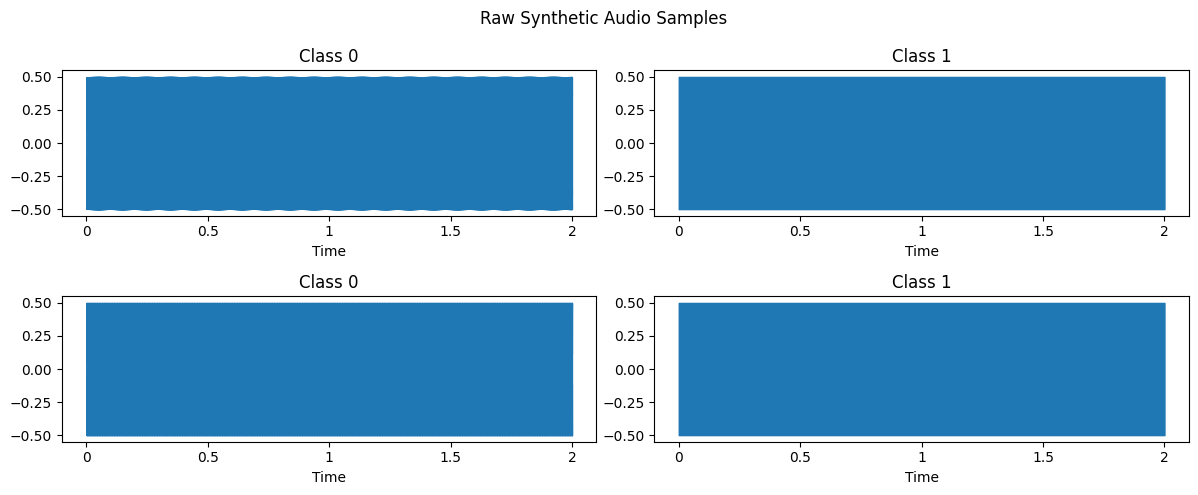

In [27]:
plt.figure(figsize=(12, 5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    librosa.display.waveshow(X[i], sr=SR)
    plt.title(f"Class {y[i]}")
plt.suptitle("Raw Synthetic Audio Samples")
plt.tight_layout()
plt.show()


In [28]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])


In [29]:
X_augmented = np.array([augment(samples=x, sample_rate=SR) for x in X])

print("Augmented Dataset Shape:", X_augmented.shape)


/usr/local/lib/python3.11/dist-packages/audiomentations/core/transforms_interface.py:108: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Augmented Dataset Shape: (100, 32000)


In [30]:
def audio_to_mel(audio, sr=SR, n_mels=64):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

X_mel = np.array([audio_to_mel(x) for x in X])
X_mel_aug = np.array([audio_to_mel(x) for x in X_augmented])

print("Mel Spectrogram Shapes:", X_mel.shape, X_mel_aug.shape)


Mel Spectrogram Shapes: (100, 64, 63) (100, 64, 63)


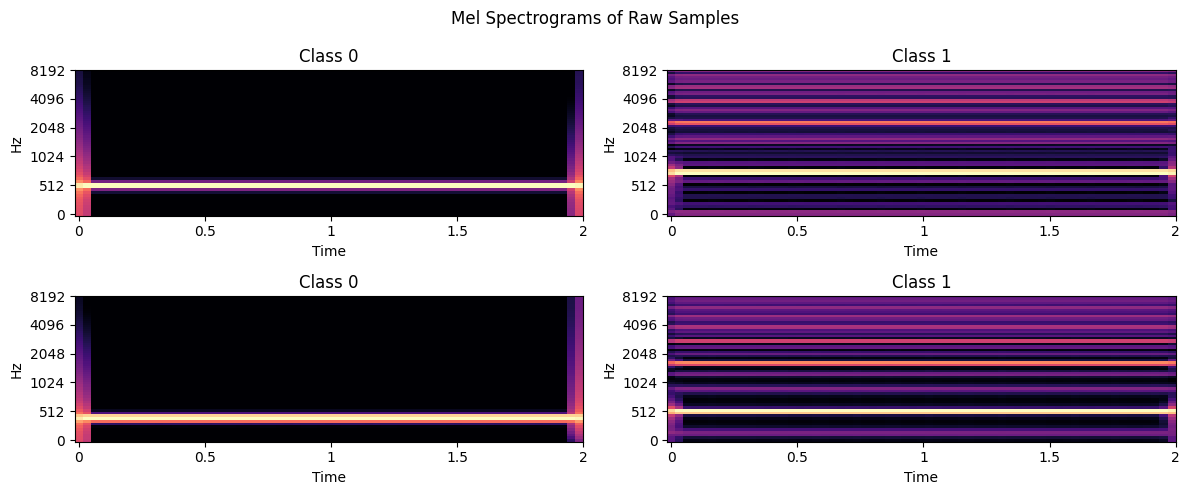

In [31]:
plt.figure(figsize=(12, 5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    librosa.display.specshow(X_mel[i], sr=SR, x_axis='time', y_axis='mel')
    plt.title(f"Class {y[i]}")
plt.suptitle("Mel Spectrograms of Raw Samples")
plt.tight_layout()
plt.show()


In [32]:
# Expand dims for CNN input
X_mel = X_mel[..., np.newaxis]
X_mel_aug = X_mel_aug[..., np.newaxis]

# Split
X_train, X_test, y_train, y_test = train_test_split(X_mel, y, test_size=0.2, random_state=42)
X_train_aug, _, y_train_aug, _ = train_test_split(X_mel_aug, y, test_size=0.2, random_state=42)


In [33]:
def build_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [34]:
model_raw = build_cnn_model(X_train.shape[1:])

history_raw = model_raw.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    verbose=2
)


Epoch 1/20
5/5 - 4s - 841ms/step - accuracy: 0.4750 - loss: 18.8695 - val_accuracy: 1.0000 - val_loss: 0.1194
Epoch 2/20
5/5 - 0s - 17ms/step - accuracy: 0.9875 - loss: 0.1428 - val_accuracy: 1.0000 - val_loss: 0.0410
Epoch 3/20
5/5 - 0s - 27ms/step - accuracy: 1.0000 - loss: 0.0625 - val_accuracy: 1.0000 - val_loss: 0.0694
Epoch 4/20
5/5 - 0s - 17ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 5/20
5/5 - 0s - 28ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 6/20
5/5 - 0s - 17ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 7/20
5/5 - 0s - 17ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 9.7771e-04
Epoch 8/20
5/5 - 0s - 28ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 7.6461e-04
Epoch 9/20
5/5 - 0s - 27ms/step - accuracy: 1.0000 - loss: 6.0813e-04 - val_accuracy: 1.0000 - val_loss: 3.6363e-04
Epoch 10/2

In [35]:
model_aug = build_cnn_model(X_train_aug.shape[1:])

history_aug = model_aug.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    verbose=2
)


Epoch 1/20
5/5 - 3s - 528ms/step - accuracy: 0.5250 - loss: 19.0044 - val_accuracy: 0.6000 - val_loss: 6.3232
Epoch 2/20
5/5 - 0s - 21ms/step - accuracy: 0.4750 - loss: 3.8788 - val_accuracy: 0.4000 - val_loss: 0.7944
Epoch 3/20
5/5 - 0s - 18ms/step - accuracy: 0.5375 - loss: 0.7684 - val_accuracy: 0.8000 - val_loss: 0.6503
Epoch 4/20
5/5 - 0s - 27ms/step - accuracy: 0.7125 - loss: 0.6516 - val_accuracy: 0.8500 - val_loss: 0.5781
Epoch 5/20
5/5 - 0s - 18ms/step - accuracy: 0.6250 - loss: 0.6237 - val_accuracy: 0.4000 - val_loss: 0.6526
Epoch 6/20
5/5 - 0s - 28ms/step - accuracy: 0.7625 - loss: 0.5893 - val_accuracy: 1.0000 - val_loss: 0.4773
Epoch 7/20
5/5 - 0s - 27ms/step - accuracy: 1.0000 - loss: 0.4539 - val_accuracy: 1.0000 - val_loss: 0.3088
Epoch 8/20
5/5 - 0s - 18ms/step - accuracy: 1.0000 - loss: 0.3244 - val_accuracy: 1.0000 - val_loss: 0.2218
Epoch 9/20
5/5 - 0s - 28ms/step - accuracy: 0.9375 - loss: 0.2789 - val_accuracy: 1.0000 - val_loss: 0.1525
Epoch 10/20
5/5 - 0s - 19m

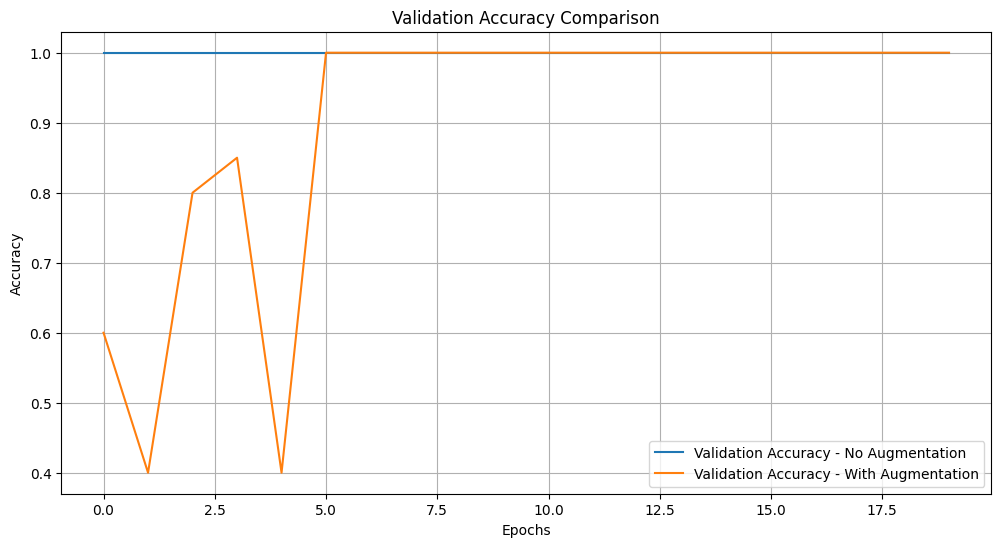

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(history_raw.history['val_accuracy'], label="Validation Accuracy - No Augmentation")
plt.plot(history_aug.history['val_accuracy'], label="Validation Accuracy - With Augmentation")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()
